In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name, is_profit=False):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{setting_name}/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit_or_cost = []
    w_holding_by_warehouse_all = []
    relevant_data_for_all = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 100
            start_step = 30
        else:
            num_steps = 200
            start_step = 100
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        s_underage = relevant_data['s_underage_costs'].sum()
        s_holding = relevant_data['s_holding_costs'].sum()
        
        # Split warehouse holding costs by warehouse
        w_holding_costs = []
        for i in range(n_warehouses):
            w_holding_costs.append(relevant_data[f'w_{i}_holding_costs'].sum())
        w_holding = sum(w_holding_costs)
        
        avg_s_underage.append(s_underage)
        avg_s_holding.append(s_holding)
        w_holding_by_warehouse_all.append(w_holding_costs)
        avg_w_holding.append(w_holding)
        
        if is_profit:
            # For profit: negate underage (revenue) and subtract costs
            profit = -s_underage - s_holding - w_holding
            avg_profit_or_cost.append(profit)
        else:
            # For loss: sum all costs
            cost = s_underage + s_holding + w_holding
            avg_profit_or_cost.append(cost)

        relevant_data_for_all.append(relevant_data)

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    
    # Add individual warehouse holding costs
    for i in range(n_warehouses):
        df_copy[f'w_{i}_holding'] = [x[i] for x in w_holding_by_warehouse_all]
        
    metric_name = 'avg_profit' if is_profit else 'avg_lost_sales'
    df_copy[metric_name] = avg_profit_or_cost
    df = df_copy

    # Calculate relative metric as percentage of best value
    if is_profit:
        best_value = df[metric_name].max()
        df['relative_metric'] = df[metric_name] / best_value * 100
    else:
        best_value = df[metric_name].min()
        df['relative_metric'] = df[metric_name] / best_value * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'] + 
                        [f'w_{i}_holding' for i in range(n_warehouses)])
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()
    
    metric_title = 'Profit' if is_profit else 'Loss'
    titles = [f'{metric_title} (% of {"maximum" if is_profit else "minimum"})', 
              'Store Revenue(1e7)' if is_profit else 'Store Lost Sales(1e7)', 
              'Store Holding Cost(1e7)', 
              'Total Warehouse Holding Cost(1e7)', 
              'Individual Warehouse Holding Costs(1e7)']
    y_values = ['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    # Create a single legend at the top
    legend_lines = []
    legend_labels = []
    for arch in df['Architecture Class'].unique():
        legend_lines.append(plt.Line2D([0], [0], color=color_scheme[arch], 
                                     linestyle=linestyle_scheme[arch], marker='o', markersize=10))
        legend_labels.append(arch)
    
    fig.legend(legend_lines, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=len(legend_labels))

    for i, (ax, title, y_value) in enumerate(zip(axes[:-1], titles[:-1], y_values)):
        for arch in df['Architecture Class'].unique():
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                if y_value != 'relative_metric':
                    plot_values = plot_values / 1e7
                x_values = np.ones_like(plot_values)
                ax.plot(x_values, plot_values, marker='o', markersize=10,
                       color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.grid(True)
        ax.set_xticks([])

    # Plot individual warehouse holding costs
    for arch in df['Architecture Class'].unique():
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_holding'].columns:
                plot_values = plot_data[f'w_{i}_holding'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-1].plot(x_values, plot_values, marker='o', markersize=10,
                            color=color_scheme[arch], linestyle=linestyle_scheme[arch])

    axes[-1].set_ylabel('Warehouse Holding Cost(1e7)')
    axes[-1].set_title('Individual Warehouse Holding Costs(1e7)')
    axes[-1].grid(True)
    axes[-1].set_xticks(range(1, n_warehouses + 1))
    axes[-1].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    return df, relevant_data_for_all


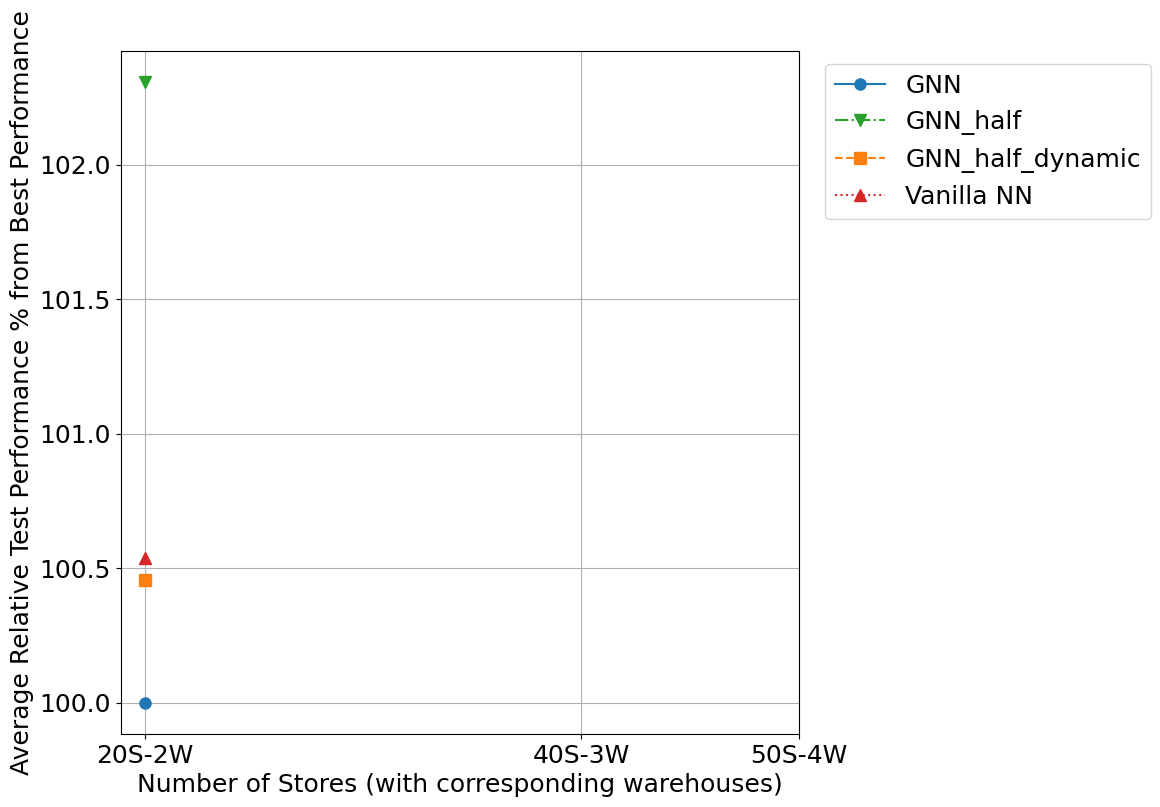

In [2]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_20_2_shock_sampled"]#, "n_warehouse_40_3_exp_short", "n_warehouse_50_4_exp_short"]
store_warehouse_pairs = {
    20: 2,
    40: 3,
    50: 4
}

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and markers for architectures
color_scheme = {
    "GNN": "#1f77b4",         # Blue
    "GNN_half": "#2ca02c",    # Green
    "GNN_half_dynamic": "#ff7f0e", # Orange
    "Vanilla NN": "#d62728",   # Red
    "GNN_skip_connection": "#9467bd",  # Purple
    "GNN_bottleneck": "#8c564b"  # Brown
}

linestyle_scheme = {
    "GNN": "-",         # Solid
    "GNN_half": "-.",   # Dash-dot
    "GNN_half_dynamic": "--", # Dashed
    "Vanilla NN": ":",   # Dotted
    "GNN_skip_connection": "-", # Solid
    "GNN_bottleneck": "--"  # Dashed
}

marker_scheme = {
    "GNN": "o",          # Circle
    "GNN_half": "v",     # Down triangle
    "GNN_half_dynamic": "s",  # Square
    "Vanilla NN": "^",    # Up triangle
    "GNN_skip_connection": "D", # Diamond
    "GNN_bottleneck": "p"  # Pentagon
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
    "GNN_half": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_half',
    "GNN_half_dynamic": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_half_dynamic',
    "Vanilla NN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/vanilla_n_warehouses',
    #"GNN_skip_connection": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_skip_connection',
    # "GNN_bottleneck": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_bottleneck'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define store sizes and sample size
store_sizes = [20, 40, 50]  # Corresponding to the testset names
sample_size = 8192

dfs = []

# Create dataframes for each architecture and store size
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        store_size = int(testset_name.split('_')[2])
        warehouse_size = store_warehouse_pairs[store_size]
        
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': [sample_size],
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['train_dev_sample_and_batch_size'] = sample_size
        df['n_warehouses'] = warehouse_size
        df['n_stores'] = store_size
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each store size
stats_by_arch_and_stores = {}
for store_size in store_sizes:
    store_data = df[df['n_stores'] == store_size].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Relative Test Performance %'] = (store_data['Test Loss']/ best_test_loss) * 100 
    
    for arch in store_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_stores:
            stats_by_arch_and_stores[key] = []
            
        arch_data = store_data[store_data['Architecture Class'] == arch]
        if not arch_data.empty:
            relative_performance = arch_data['Relative Test Performance %'].to_numpy()
            mean_relative_performance = np.mean(relative_performance)
            std_relative_performance = np.std(relative_performance)
            ci_95 = 1.96 * std_relative_performance / np.sqrt(len(relative_performance))
            stats_by_arch_and_stores[key].append({
                'n_stores': store_size,
                'mean_relative_performance': mean_relative_performance,
                'ci_lower': mean_relative_performance - ci_95,
                'ci_upper': mean_relative_performance + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        stores_array = stats_df['n_stores'].to_numpy()
        mean_relative_performance_array = stats_df['mean_relative_performance'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(stores_array, mean_relative_performance_array,
                marker=marker_scheme[arch],
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                markersize=8,
                label=arch)
        
        plt.fill_between(stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Stores (with corresponding warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Relative Test Performance % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create single legend
plt.legend(bbox_to_anchor=(1.02, 1),
          loc='upper left',
          fontsize=FONTSIZE)

# Update x-axis ticks to show store-warehouse pairs
plt.xticks(store_sizes, [f'{s}S-{store_warehouse_pairs[s]}W' for s in store_sizes], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [6]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,GNN,8192,GNN,1,0.001,4.848286,4.861688,4.856918,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
1,1,GNN_half,8192,GNN_half,1,0.001,4.963458,4.973484,4.968967,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
2,1,GNN_half_dynamic,8192,GNN_half_dynamic,1,0.001,4.870307,4.882983,4.879094,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
3,1,Vanilla NN,8192,Vanilla NN,1,0.001,4.859582,4.887129,4.883015,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20


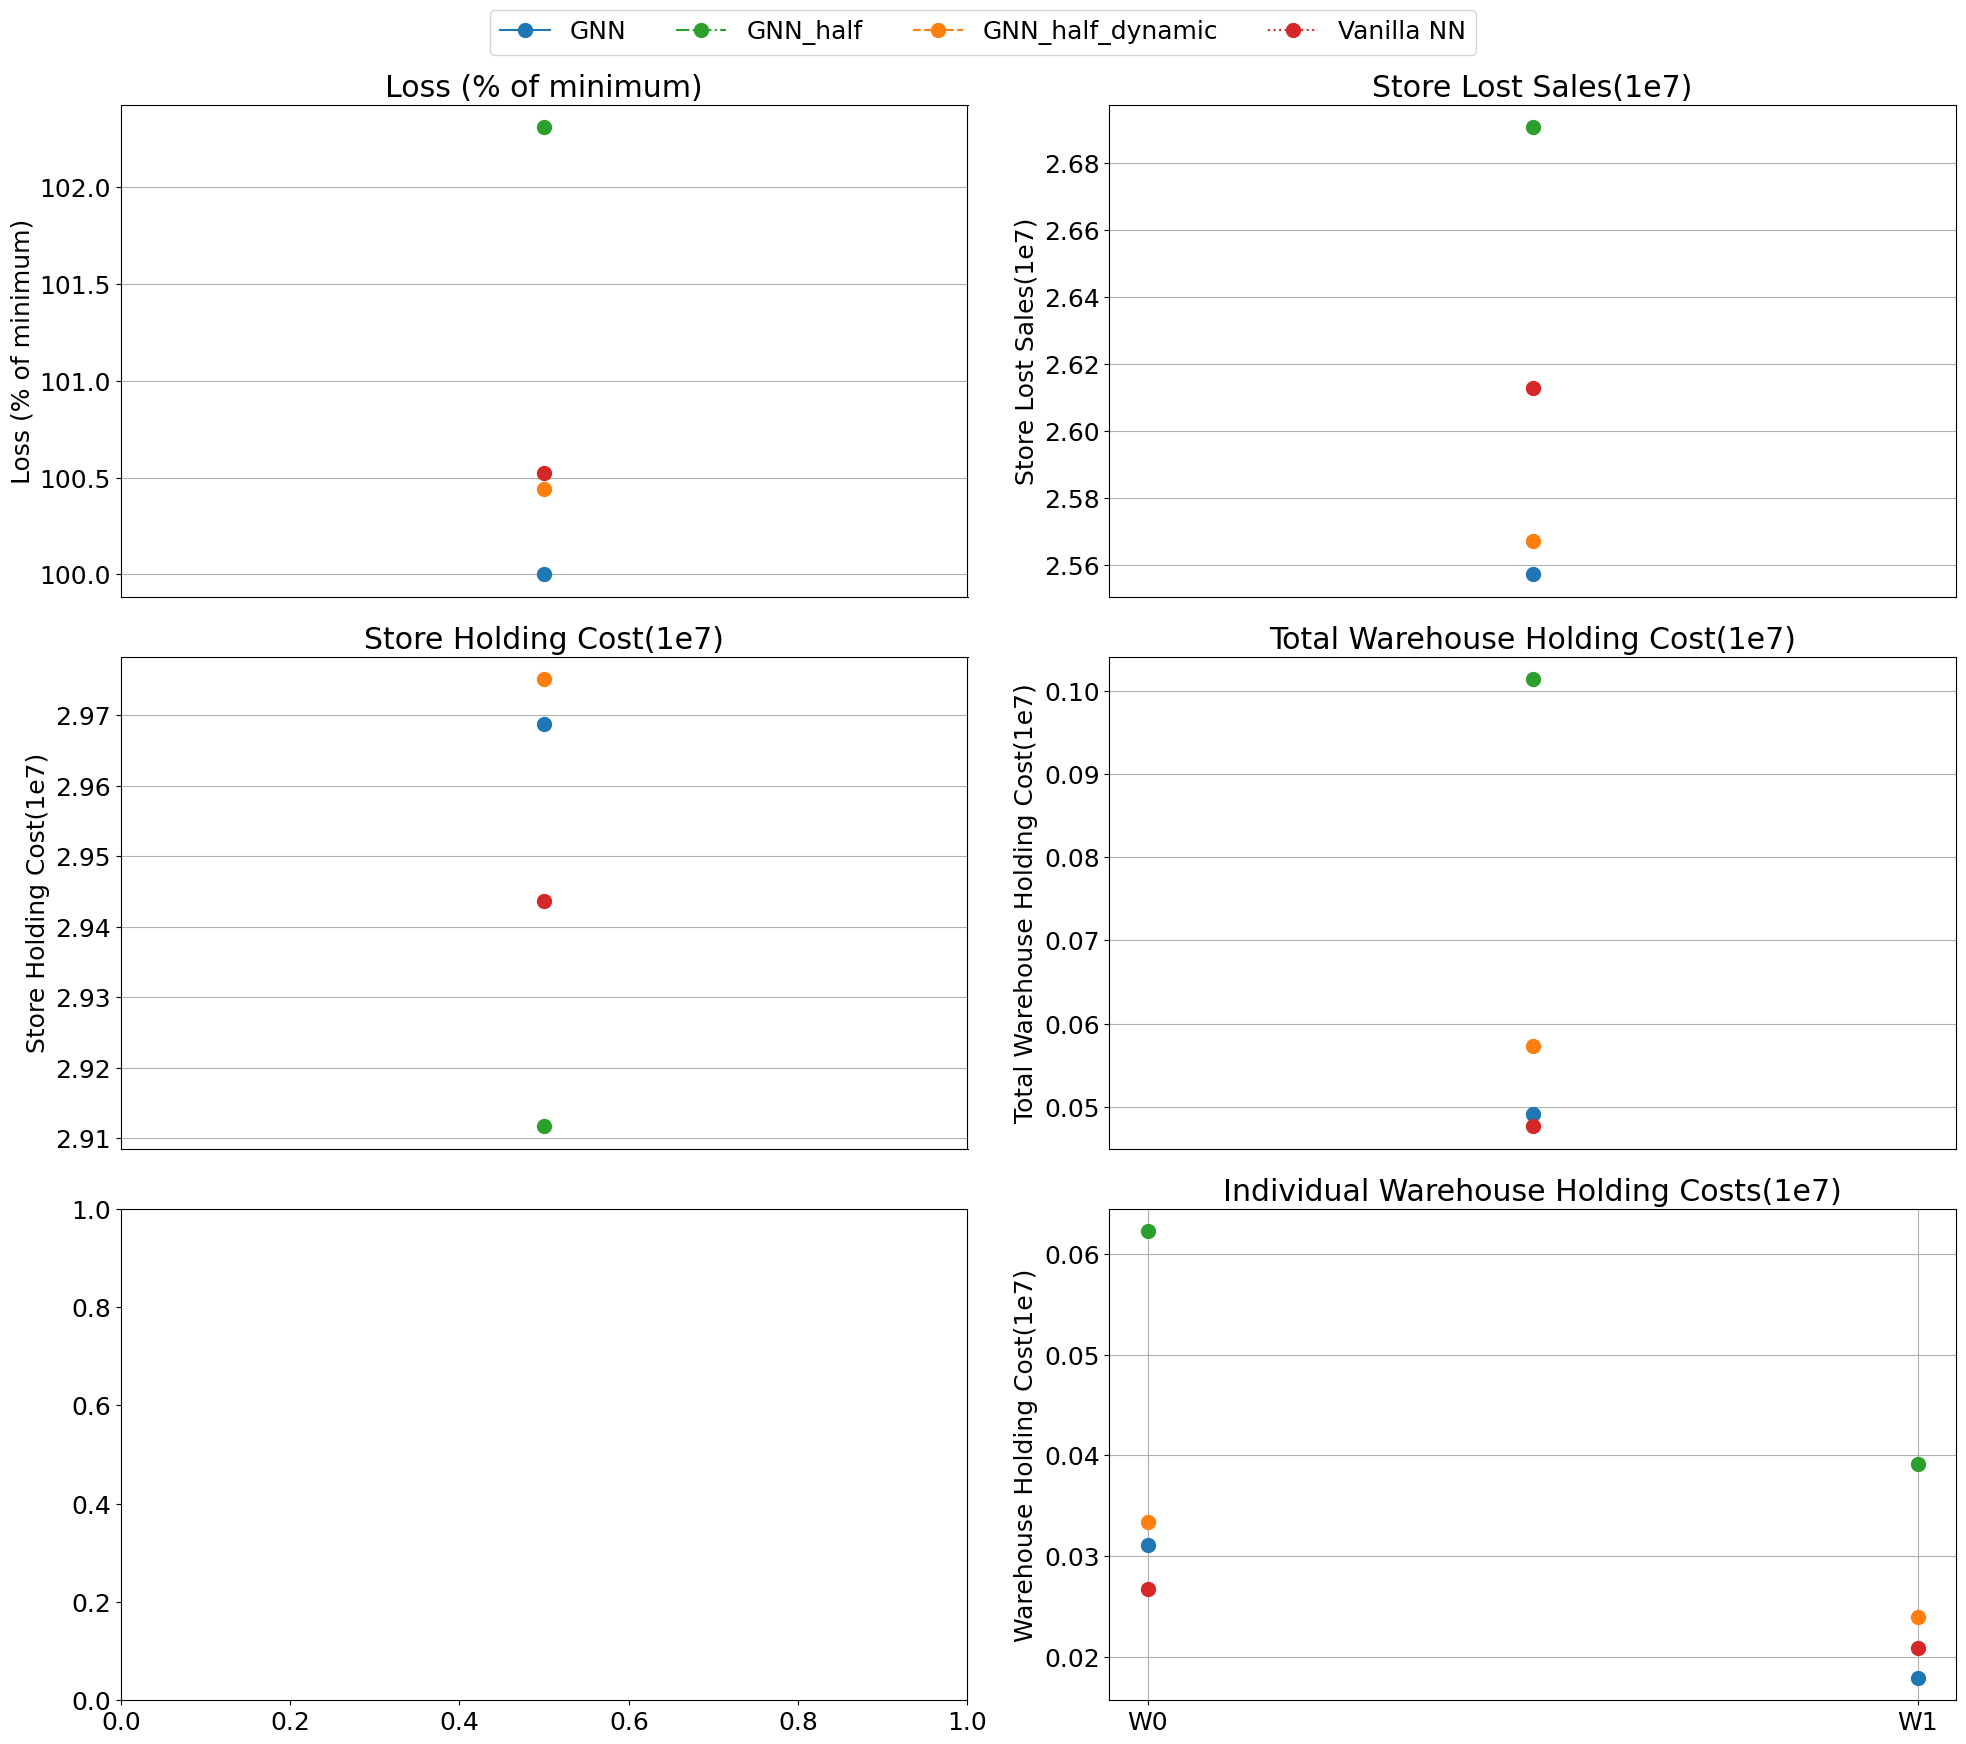

In [5]:
df_analysis = df[df['n_warehouses'] == 2]
df_analysis = df_analysis[df_analysis['Architecture Class'] != 'GNN_half_old']
df_analysis.loc[df_analysis['Architecture Class'] == 'Vanilla NN', 'hyperparam_name'] = 'vanilla_n_warehouses'

sample_size = 8192
df, data = collect_data_and_plot(df_analysis, 20, 2, sample_size, "test_on_dev", "n_warehouse_20_2_lost_demand_shock_sampled")

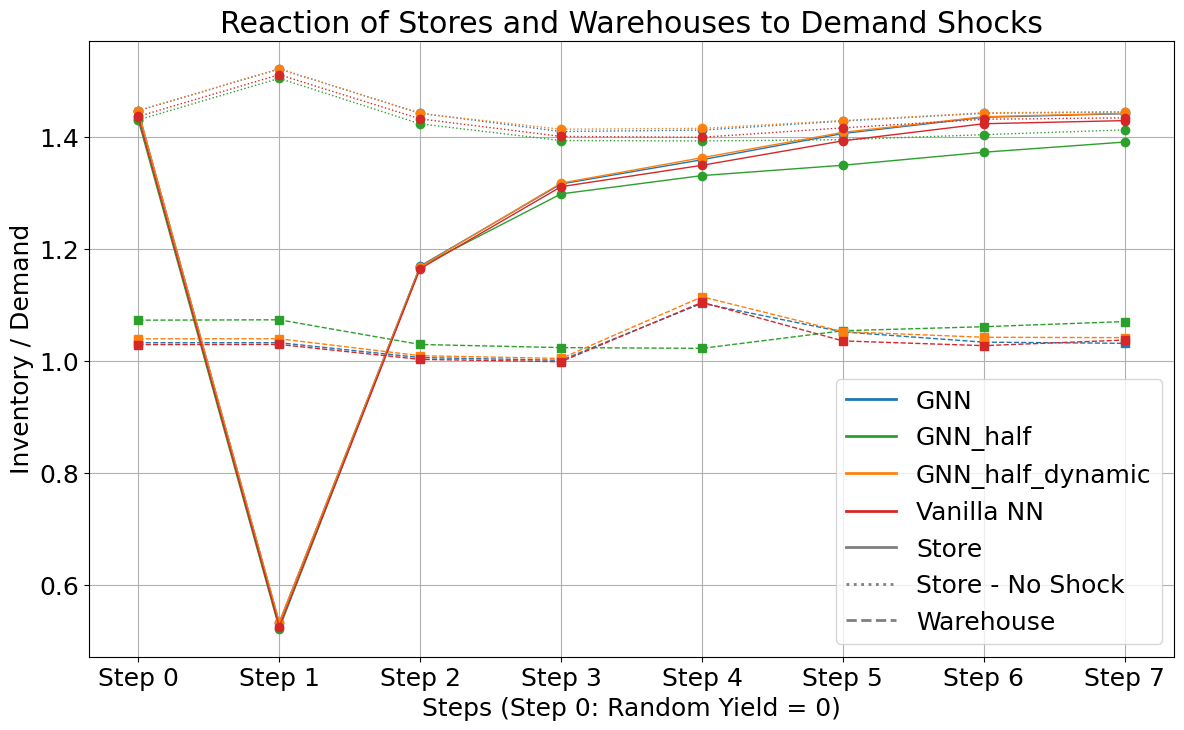

In [6]:
step_labels = ['Step 0', 'Step 1', 'Step 2', 'Step 3', 'Step 4', 'Step 5', 'Step 6', 'Step 7']
arch_names = ['GNN', 'GNN_half', 'GNN_half_dynamic', 'Vanilla NN']

n_stores = 20
n_warehouses = 2
plt.figure(figsize=(14, 8))

# Store data for table
warehouse_depletion_percentages = {}
inventory_ratio_data = {}
warehouse_ratio_data = {}

for arch_name in arch_names:
    target_data = data[arch_names.index(arch_name)]
    n_steps = len(target_data) // sample_size

    inventory_ratio_means = [[] for _ in range(len(step_labels))]
    for step in range(n_steps - len(step_labels)):
        for store_idx in range(n_stores):
            step_indices = [
                np.arange(sample_size) + (step + i) * sample_size 
                for i in range(len(step_labels))
            ]
            
            current_yields = target_data[f's_{store_idx}_random_yields'].iloc[step_indices[0]].values
            mask = (current_yields == 0)
            
            if np.any(mask):
                filtered_indices = [indices[mask] for indices in step_indices]
                
                for idx, indices in enumerate(filtered_indices):
                    demand_means = target_data[f's_{store_idx}_demand_mean'].iloc[indices].values
                    inventories = target_data[f's_{store_idx}_inventory_0'].iloc[indices].values
                    ratios = inventories / demand_means
                    inventory_ratio_means[idx].extend(ratios)

    # Calculate the average across all stores and steps
    inventory_ratio_means_result = [np.mean(ratio) for ratio in inventory_ratio_means]
    inventory_ratio_data[arch_name] = inventory_ratio_means_result
    plt.plot(step_labels, inventory_ratio_means_result, marker='o', color=color_scheme[arch_name], linewidth=1, label=arch_name)
    
    # Add warehouse inventory to demand ratio
    warehouse_ratio_means = []
    # Track warehouse depletion at step 1 (after random yield = 0 at step 0)
    warehouse_depletion_list = []
    inventory_ratio_means_no_shock = [[] for _ in range(len(step_labels))]
    for step in range(n_steps - len(step_labels)):
        step_indices = [
            np.arange(sample_size) + (step + i) * sample_size 
            for i in range(len(step_labels))
        ]
        
        # Find instances where random yield is 0 at step 0 for any store
        mask = None
        for store_idx in range(n_stores):
            current_yields = target_data[f's_{store_idx}_random_yields'].iloc[step_indices[0]].values
            store_mask = (current_yields == 0)
            if mask is None:
                mask = store_mask
            else:
                mask = mask | store_mask
                
        if np.any(mask):
            filtered_indices = [indices[mask] for indices in step_indices]
            for store_idx in range(n_stores):
                current_yields = target_data[f's_{store_idx}_random_yields'].iloc[filtered_indices[0]].values
                mask_no_shock = (current_yields == 1)
                for idx, indices in enumerate(filtered_indices):
                    demand_means = target_data[f's_{store_idx}_demand_mean'].iloc[filtered_indices[idx][mask_no_shock]].values
                    inventories = target_data[f's_{store_idx}_inventory_0'].iloc[filtered_indices[idx][mask_no_shock]].values
                    ratios = inventories / demand_means
                    inventory_ratio_means_no_shock[idx].extend(ratios)
        
        if np.any(mask):
            filtered_indices = [indices[mask] for indices in step_indices]
            
            step_ratios = []
            for indices in filtered_indices:
                # Sum all warehouse inventories
                total_warehouse_inventory = np.zeros(len(indices))
                for w_idx in range(n_warehouses):
                    warehouse_inv = target_data[f'w_{w_idx}_inventory'].iloc[indices].values
                    total_warehouse_inventory += warehouse_inv
                
                # Sum all store demands
                total_store_demand = np.zeros(len(indices))
                for store_idx in range(n_stores):
                    store_demand = target_data[f's_{store_idx}_demand_mean'].iloc[indices].values
                    total_store_demand += store_demand
                
                # Calculate ratio of total warehouse inventory to total store demand
                ratios = total_warehouse_inventory / total_store_demand
                step_ratios.append(ratios)
            
            step1_indices = filtered_indices[1]
            
            # Sum all warehouse inventories at step 0
            total_warehouse_inventory = np.zeros(len(step1_indices))
            for w_idx in range(n_warehouses):
                warehouse_inv = target_data[f'w_{w_idx}_inventory'].iloc[step1_indices].values
                total_warehouse_inventory += warehouse_inv
            
            # Sum all store orders to warehouses at step 0
            total_store_orders = np.zeros(len(step1_indices))
            for store_idx in range(n_stores):
                for w_idx in range(n_warehouses):
                    if f's_{store_idx}_w_{w_idx}_order' in target_data:
                        store_orders = target_data[f's_{store_idx}_w_{w_idx}_order'].iloc[step1_indices].values
                        total_store_orders += store_orders
            
            # Check if warehouse inventory equals store orders (with 0.1 error margin)
            is_depleted = np.abs(total_warehouse_inventory - total_store_orders) <= 0.1
            warehouse_depletion_list.extend(is_depleted)
            
            if len(warehouse_ratio_means) == 0:
                warehouse_ratio_means = step_ratios
            else:
                for i in range(len(step_labels)):
                    warehouse_ratio_means[i] = np.concatenate([warehouse_ratio_means[i], step_ratios[i]])
    
    depletion_percentage = np.mean(warehouse_depletion_list) * 100
    warehouse_depletion_percentages[arch_name] = depletion_percentage
    warehouse_ratio_avgs = [np.mean(ratios) for ratios in warehouse_ratio_means]
    warehouse_ratio_data[arch_name] = warehouse_ratio_avgs
    
    plt.plot(step_labels, warehouse_ratio_avgs, marker='s', color=color_scheme[arch_name], linewidth=1, 
             linestyle='--', label=f"{arch_name} - Warehouse")

    inventory_ratio_means_no_shock_result = [np.mean(ratio) for ratio in inventory_ratio_means_no_shock]
    plt.plot(step_labels, inventory_ratio_means_no_shock_result, marker='o', color=color_scheme[arch_name], linewidth=1, linestyle=':', label=f"{arch_name} - No Shock")
    
# Create custom legend handles
from matplotlib.lines import Line2D

# Create legend for architectures (colors)
arch_handles = []
unique_archs = set()  # Track unique architecture names
for df_row in df.itertuples():
    arch_name = df_row._4  # Architecture Class column
    if arch_name not in unique_archs:
        unique_archs.add(arch_name)
        arch_handles.append(Line2D([0], [0], color=color_scheme[arch_name], lw=2, label=arch_name))

# Create legend for inventory types (line styles)
style_handles = [
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Store'),
    Line2D([0], [0], color='gray', lw=2, linestyle=':', label='Store - No Shock'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Warehouse')
]

# Add both legend groups
plt.xlabel('Steps (Step 0: Random Yield = 0)')
plt.ylabel('Inventory / Demand')
plt.title('Reaction of Stores and Warehouses to Demand Shocks')
plt.grid(True)
plt.legend(handles=arch_handles + style_handles, loc='best')
plt.show()

In [7]:
import pandas as pd
from IPython.display import display

# Table 1: Warehouse Depletion Percentages
depletion_df = pd.DataFrame({
    'Architecture': list(warehouse_depletion_percentages.keys()),
    'Warehouse Depletion After Shock (%)': [f"{val:.2f}" for val in warehouse_depletion_percentages.values()]
})
print("\nWarehouse Depletion Percentages:")
display(depletion_df)
# Table 2: Store Inventory/Demand Ratios
store_df = pd.DataFrame(inventory_ratio_data, index=step_labels).T
store_df.index.name = 'Architecture'
print("\nStore Inventory/Demand Ratios:")
display(store_df)

# Table 3: Warehouse Inventory/Demand Ratios
warehouse_df = pd.DataFrame(warehouse_ratio_data, index=step_labels).T
warehouse_df.index.name = 'Architecture'
print("\nWarehouse Inventory/Demand Ratios:")
display(warehouse_df)


Warehouse Depletion Percentages:


,Architecture,Warehouse Depletion After Shock (%)
0,GNN,90.65
1,GNN_half,78.55
2,GNN_half_dynamic,85.82
3,Vanilla NN,65.25



Store Inventory/Demand Ratios:


,Step 0,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7
Architecture,,,,,,,,
GNN,1.445741,0.532619,1.169665,1.316209,1.359590,1.406395,1.435392,1.441858
GNN_half,1.429830,0.521597,1.168656,1.298503,1.331210,1.349695,1.372928,1.391135
GNN_half_dynamic,1.446146,0.533409,1.168146,1.317769,1.363176,1.408455,1.436412,1.442470
Vanilla NN,1.435784,0.525150,1.164842,1.311414,1.349613,1.393330,1.423854,1.429435



Warehouse Inventory/Demand Ratios:


,Step 0,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7
Architecture,,,,,,,,
GNN,1.032609,1.032652,1.006103,1.001198,1.103103,1.051914,1.033639,1.031482
GNN_half,1.072877,1.073549,1.029436,1.023895,1.022552,1.054030,1.061188,1.070381
GNN_half_dynamic,1.039563,1.039669,1.009402,1.004472,1.114685,1.052330,1.042350,1.041666
Vanilla NN,1.029217,1.029487,1.002857,0.998686,1.104781,1.035814,1.027343,1.037386


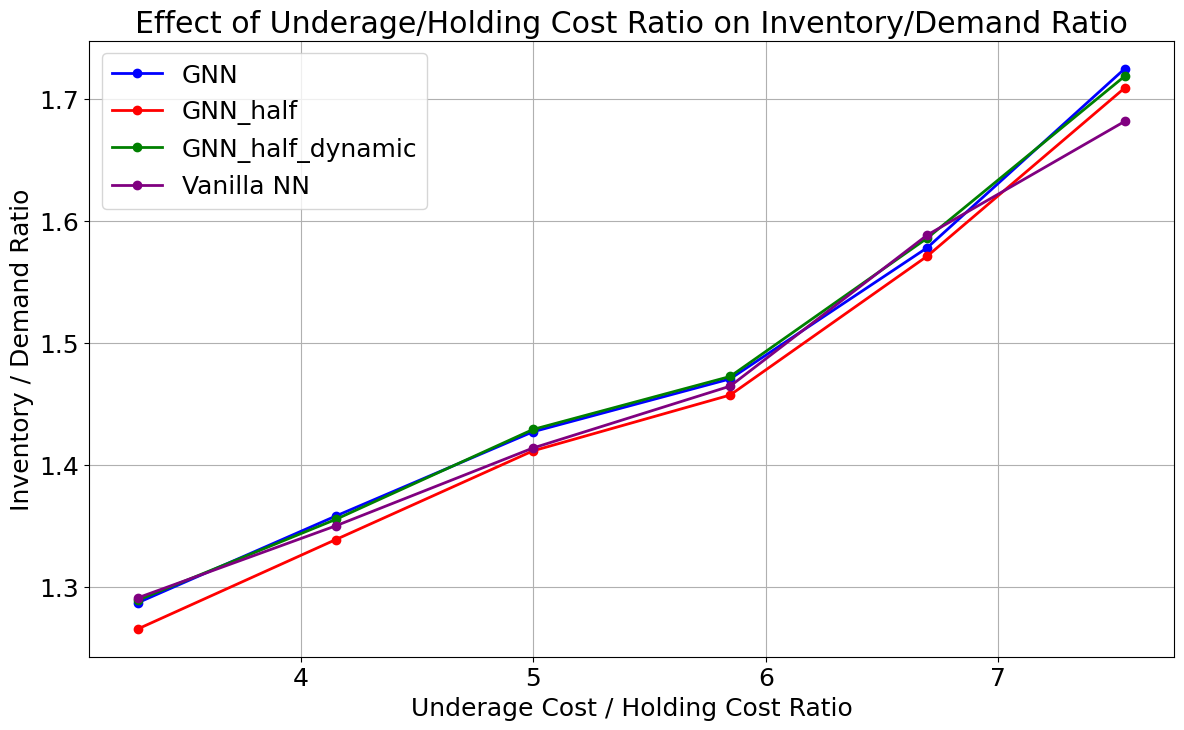

In [8]:
# Create figure for the underage cost vs inventory/demand plot
plt.figure(figsize=(14, 8))
colors = ['blue', 'red', 'green', 'purple']  # Colors for each architecture
arch_names = ['GNN', 'GNN_half', 'GNN_half_dynamic', 'Vanilla NN']

# Number of bins for underage costs
num_bins = 6
n_stores = 20

for data_idx, (arch_name, color) in enumerate(zip(arch_names, colors)):
    target_data = data[data_idx]
    n_steps = len(target_data) // sample_size
    
    # Collect underage costs and corresponding inventory/demand ratios
    all_cost_ratios = []
    all_inv_demand_ratios = []

    for step in range(n_steps):
        for store_idx in range(n_stores):
            step_indices = np.arange(sample_size) + step * sample_size
            underage_costs = target_data[f's_{store_idx}_underage_costs'].iloc[step_indices].values
            holding_costs = target_data[f's_{store_idx}_holding_costs'].iloc[step_indices].values
            cost_ratios = underage_costs / holding_costs
            demand_means = target_data[f's_{store_idx}_demand_mean'].iloc[step_indices].values
            inventories = target_data[f's_{store_idx}_inventory_0'].iloc[step_indices].values
            inv_demand_ratios = inventories / demand_means
            all_cost_ratios.extend(cost_ratios)
            all_inv_demand_ratios.extend(inv_demand_ratios)
    
    # If we have data for this architecture
    if all_cost_ratios:
        # Convert to numpy arrays
        all_cost_ratios = np.array(all_cost_ratios)
        all_inv_demand_ratios = np.array(all_inv_demand_ratios)
        
        # Find min and max cost ratios
        min_ratio = np.min(all_cost_ratios)
        max_ratio = np.max(all_cost_ratios)
        
        # Create bins
        bin_edges = np.linspace(min_ratio, max_ratio, num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Initialize arrays for binned data
        binned_ratios = []
        
        # Bin the data
        for i in range(num_bins):
            bin_mask = (all_cost_ratios >= bin_edges[i]) & (all_cost_ratios < bin_edges[i+1])
            if np.any(bin_mask):
                binned_ratios.append(np.mean(all_inv_demand_ratios[bin_mask]))
            else:
                binned_ratios.append(np.nan)  # No data in this bin
        
        # Plot for this architecture
        plt.plot(bin_centers, binned_ratios, marker='o', color=color, linewidth=2, label=arch_name)

# Add labels and legend
plt.xlabel('Underage Cost / Holding Cost Ratio')
plt.ylabel('Inventory / Demand Ratio')
plt.title('Effect of Underage/Holding Cost Ratio on Inventory/Demand Ratio')
plt.grid(True)
plt.legend(loc='best')
plt.show()

/tmp/ipykernel_28297/2657249149.py:46: RuntimeWarning: All-NaN slice encountered
  sample_mins = np.nanmin(step_tensor[:,:,0], axis=1, keepdims=True)
/tmp/ipykernel_28297/2657249149.py:47: RuntimeWarning: All-NaN slice encountered
  sample_maxs = np.nanmax(step_tensor[:,:,0], axis=1, keepdims=True)
/tmp/ipykernel_28297/2657249149.py:46: RuntimeWarning: All-NaN slice encountered
  sample_mins = np.nanmin(step_tensor[:,:,0], axis=1, keepdims=True)
/tmp/ipykernel_28297/2657249149.py:47: RuntimeWarning: All-NaN slice encountered
  sample_maxs = np.nanmax(step_tensor[:,:,0], axis=1, keepdims=True)
/tmp/ipykernel_28297/2657249149.py:46: RuntimeWarning: All-NaN slice encountered
  sample_mins = np.nanmin(step_tensor[:,:,0], axis=1, keepdims=True)
/tmp/ipykernel_28297/2657249149.py:47: RuntimeWarning: All-NaN slice encountered
  sample_maxs = np.nanmax(step_tensor[:,:,0], axis=1, keepdims=True)
/tmp/ipykernel_28297/2657249149.py:46: RuntimeWarning: All-NaN slice encountered
  sample_mins = np.

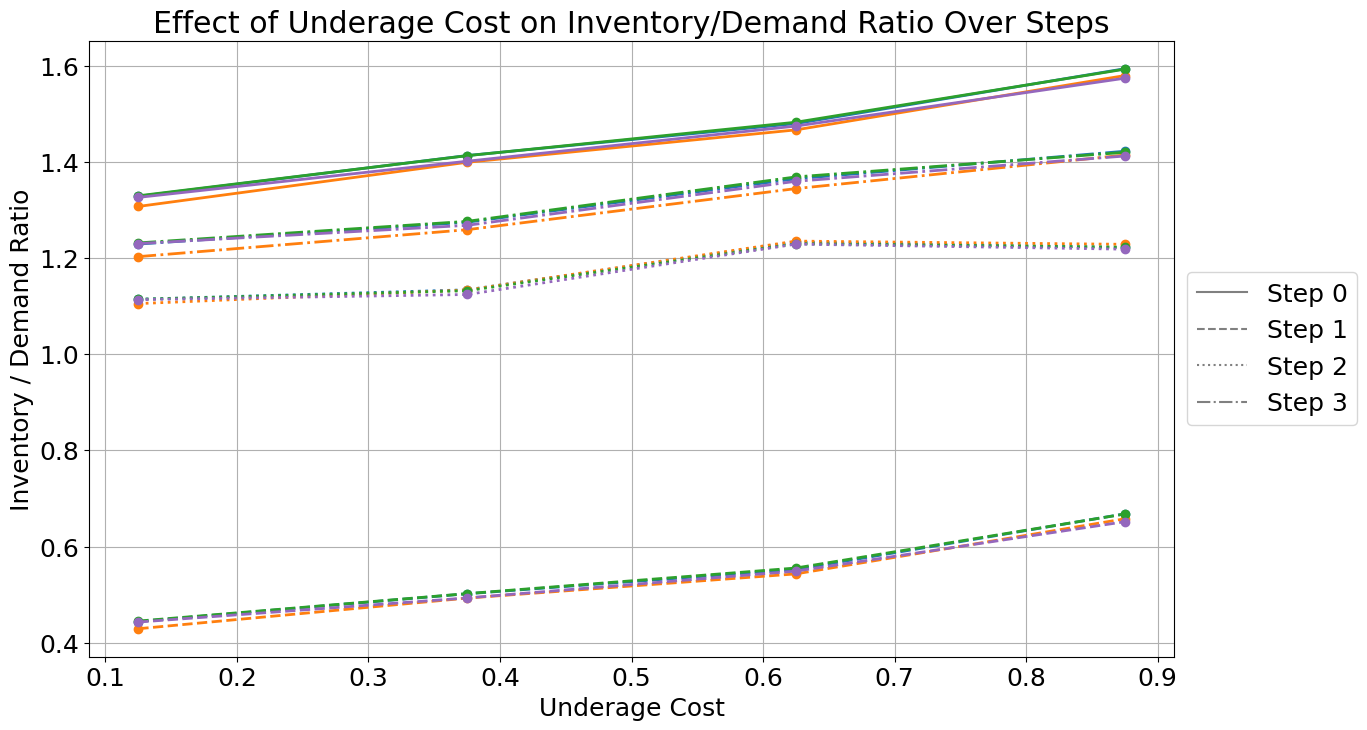

In [14]:
# Create figure for the underage cost vs inventory/demand plot
plt.figure(figsize=(14, 8))
arch_names = ['GNN', 'GNN_half', 'GNN_half_dynamic', 'Vanilla NN']
line_styles = ['-', '--', ':', '-.']  # Different line styles for each step

# Number of bins for underage costs
num_bins = 4
n_stores = 20

for arch_name in arch_names:
    data_idx = arch_names.index(arch_name)
    target_data = data[data_idx]
    n_steps = len(target_data) // sample_size
    
    # Process each step separately
    for step_offset, line_style in enumerate(line_styles):
        # Collect underage costs and corresponding inventory/demand ratios
        all_underage_costs = []
        all_inv_demand_ratios = []

        for step in range(n_steps - 3):
            step0_indices = np.arange(sample_size) + step * sample_size
            step1_indices = np.arange(sample_size) + (step + 1) * sample_size
            step2_indices = np.arange(sample_size) + (step + 2) * sample_size
            step3_indices = np.arange(sample_size) + (step + 3) * sample_size
            target_indices = np.arange(sample_size) + (step + step_offset) * sample_size

            # Initialize tensor with NaN values
            step_tensor = np.full((sample_size, n_stores, 2), np.nan)
            for store_idx in range(n_stores):
                current_yields = target_data[f's_{store_idx}_random_yields'].iloc[step0_indices].values
                mask = (current_yields == 0)
                
                # Get values for this store
                underage_costs = target_data[f's_{store_idx}_underage_costs'].iloc[target_indices].values
                holding_costs = target_data[f's_{store_idx}_holding_costs'].iloc[target_indices].values
                demand_means = target_data[f's_{store_idx}_demand_mean'].iloc[target_indices].values
                inventories = target_data[f's_{store_idx}_inventory_0'].iloc[target_indices].values
                inv_demand_ratios = inventories / demand_means
                
                # Fill tensor where mask is True
                step_tensor[mask, store_idx, 0] = underage_costs[mask] / holding_costs[mask]
                step_tensor[mask, store_idx, 1] = inv_demand_ratios[mask]
                
            valid_mask = ~np.isnan(step_tensor[:,:,0])
            sample_mins = np.nanmin(step_tensor[:,:,0], axis=1, keepdims=True)
            sample_maxs = np.nanmax(step_tensor[:,:,0], axis=1, keepdims=True)
            normalized_costs = (step_tensor[:,:,0] - sample_mins) / (sample_maxs - sample_mins)
            all_underage_costs.extend(normalized_costs[valid_mask].flatten())
            all_inv_demand_ratios.extend(step_tensor[:,:,1][valid_mask].flatten())
        
        if all_underage_costs:
            # Convert to numpy arrays
            all_underage_costs = np.array(all_underage_costs)
            all_inv_demand_ratios = np.array(all_inv_demand_ratios)
            
            # Find min and max underage costs
            min_cost = np.min(all_underage_costs)
            max_cost = np.max(all_underage_costs)
            
            # Create bins
            bin_edges = np.linspace(min_cost, max_cost, num_bins + 1)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Initialize arrays for binned data
            binned_ratios = []
            
            # Bin the data
            for i in range(num_bins):
                bin_mask = (all_underage_costs >= bin_edges[i]) & (all_underage_costs < bin_edges[i+1])
                if np.any(bin_mask):
                    binned_ratios.append(np.mean(all_inv_demand_ratios[bin_mask]))
                else:
                    binned_ratios.append(np.nan)  # No data in this bin
            
            # Plot for this architecture and step
            if step_offset == 0:
                # First plot for architecture - add to legend
                plt.plot(bin_centers, binned_ratios, marker='o', color=color_scheme[arch_name],
                        linestyle=line_style, linewidth=2, label=arch_name)
            else:
                # Subsequent plots - no legend entry
                plt.plot(bin_centers, binned_ratios, marker='o', color=color_scheme[arch_name],
                        linestyle=line_style, linewidth=2)

# Add labels and legend
plt.xlabel('Underage Cost')
plt.ylabel('Inventory / Demand Ratio')
plt.title('Effect of Underage Cost on Inventory/Demand Ratio Over Steps')
plt.grid(True)

# Add step legend
step_legend = [plt.Line2D([0], [0], color='gray', linestyle=style, label=f'Step {i}') 
               for i, style in enumerate(['-', '--', ':', '-.'])]
plt.legend(handles=step_legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()